##Importação de dados em JSON e conversão em Pickled DataFrames


In [ ]:
!pip install unidecode
!pip install pydot

     |████████████████████████████████| 245kB 5.2MB/s 


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import json
import datetime
import os
import pickle
import warnings
import operator

from networkx.drawing.nx_agraph import graphviz_layout
from sklearn.preprocessing import normalize
from matplotlib.cm import ScalarMappable
from sklearn.cluster import Birch
from unidecode import unidecode
from google.colab import drive

%matplotlib inline

sns.set()

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Rodar apenas uma vez
# Descompactando os arquivos dos TRTs
!unzip drive/My\ Drive/Dados/justica_trabalho.zip
# Descompactando os arquivos dos Tribunais Superiores
!unzip drive/My\ Drive/Dados/tribunais_superiores.zip
# Criando a pasta de Processos
!mkdir drive/My\ Drive/Dados/Processos
# Movendo as pastas de cada TRT para Processos
!mv processos-trt* drive/My\ Drive/Dados/Processos
# Copiando apenas a pasta do TST, que será renomeada para "trt25"
!mv processos-tst drive/My\ Drive/Dados/Processos
# Listando para verificação
!ls -R drive/My\ Drive/Dados/Processos

In [ ]:
# Rodar apenas uma vez
# Esta função opera em todas as pastas encontradas em 'path', uma a uma, tentando converter
# os arquivos contidos nelas de JSON para .pkl. Desta forma, é necessário que exista ao menos
# uma pasta, e que só hajam arquivos JSON dentro de quaisquer pastas que existirem.
def JSON_to_pickle():
  path = 'drive/My Drive/Dados/Processos'

  for trt in os.listdir(path):
    if (os.path.isfile(path+'/'+trt)):
      continue
    print(trt)
    for filename in os.listdir(path+'/'+trt):  
      with open(path+'/'+trt+'/'+filename, 'r') as f:
        data = f.read()
      obj = json.loads(data)
      with open(path+'/'+trt+'/'+filename.rsplit('.json',1)[0]+'.pkl', 'xb') as f:
        pickle.dump(obj,f)

    !rm drive/My\ Drive/Dados/Processos/$trt/*.json

In [ ]:
# Rodar apenas uma vez por TRT
# Esta função espera encontrar os 6 arquivos JSON originais em cada pasta convertidos para .pkl, e a partir deles
# construir apenas um arquivo .pkl para cada TRT, já convertendo o dicionário em Panda DataFrame.
# A exceção é o TRT5, cujo DataFrame após este passo não cabe em RAM (código executado no Google Colab, em
# um runtime com 12.72 GB de RAM). Neste caso, foram construídos 2 arquivos, 5_1.pkl e 5_2.pkl para ele.
# Parâmetro: número do TRT a ser convertido.
def PKLlist_to_PKLdataframe(numerotrt: int):

  # Conversão de pickled lists de um TRT para pickled DataFrame
  keys = ['millisInsercao','grau','siglaTribunal','dadosBasicos','movimento']
  path = 'drive/My Drive/Dados/Processos/processos-trt'+str(numerotrt)

  # Inicializando Array vazio
  array = np.empty((1,len(keys)),dtype=object)

  # Lendo todos os arquivos de processos de um TRT
  for filename in os.listdir(path):

    # Obtendo um dos arquivos
    lst = pd.read_pickle(path+'/'+filename)
    for i in range(len(lst)):
      values = []

      # Obtendo os valores desejados do arquivo
      for key in keys:
        values.append(lst[i].get(key))

      # Acrescentando os valores no final do Array
      array[array.shape[0]-1] = values

      # Aumentando o tamanho do Array
      array.resize((array.shape[0]+1,len(keys)))

  # Convertendo array em DataFrame, e setando o nome das colunas
  df = pd.DataFrame(array)
  df.columns = keys
  with open(path+'.pkl','xb') as f:
    df.to_pickle(f)

In [ ]:
# Este bloco tem como objetivo, a conversão do dicionário de 'dadosBasicos' em colunas, pois foi verificado
# em análise exploratória que embora ele possa conter muitos parâmetros, poucos (13, neste caso) são de 
# fato utilizados pelos processos dos TRTs que recebemos. Optamos por convertê-los em colunas para facilitar
# as próximas análises.

# A função abaixo percorre os TRTs um a um verificando os dadosBasicos utilizados nele, e construindo um 
# DataFrame unificado, no formato descrito abaixo.
def get_dadosBasicos():

  # Construir um DataFrame com a lista de dados básicos de cada processo, colunas = processo, linhas = TRTs (menos o 5)
  dadosBasicos_total = []

  # Iterar sobre todos os TRTs
  for i in range(1,26):
    if (i == 5): # Não cabe em RAM, foi assumido que ele tem os mesmos dadosBasicos dos demais 
      continue
    with open('drive/My Drive/Dados/Processos/processos-trt'+str(i)+'.pkl','rb') as f:
      df = pd.read_pickle(f)

    # Lista contendo os dadosBasicos utilizados por um determinado processo
    dadosBasicos_por_processo = []

    # Lista contendo os dadosBasicos utilizador por um determinado TRT, sendo cada processo um elemento da lista
    dadosBasicos_por_trt = []

    # Iterar sobre os processos
    for item in df.dadosBasicos.items():
      # Obter o elemento [1] do iterador da forma [index, dadosBasicos]
      dadosBasicos_por_processo.append(list(item)[1])
    # Remover o último elemento, pois a biblioteca pandas adiciona uma linha com 0s ao final de cada DataFrame, que deve
    # ser descartada
    dadosBasicos_por_processo.pop()

    # Iterar sobre os dadosBasicos do processo
    for i in dadosBasicos_por_processo:
      # Obter as chaves do dicionário dadosBasicos
      dadosBasicos_por_trt.append(list(i.keys()))

    # Concatenar a lista de chaves de dadosBasicos por processo, de todo o TRT em uma linha do que será o DataFrame final
    dadosBasicos_total.append(dadosBasicos_por_trt)

  # Converter para DataFrame
  dfl = pd.DataFrame(dadosBasicos_total)
  return dfl
  
# Função auxiliar que retorna os elementos únicos de uma lista, ou o conjunto vazio se a lista não tiver elementos
def element_to_set(x):
  # Convertendo a lista para conjuntos, ou retornar o conjunto vazio, se o valor for 'None'
  if (x):
    return set(x)
  return set()

# Aplicar a função acima em cada célula do DataFrame passado como parâmetro, para converter seus valores em conjuntos
def get_df_as_set(dfl):
  # Aplicando em todos os elementos do DF
  dfl_as_set = dfl.applymap(lambda x: element_to_set(x))
  return dfl_as_set

# Esta função pega o DataFrame criado na primeira função deste bloco, aplica nele a função acima para converter as
# células em conjuntos, e percorre todo o DataFrame unindo cada célula à célula [0][0]. Desta forma, ao final da 
# função, é possível retornar o valor da célula [0][0] que contém a união dos conjuntos dadosBasicos de cada
# processo do dataset
def get_dadosBasicos_as_list(): 
  dfl = get_dadosBasicos()
  dfl_as_set = get_df_as_set(dfl)

  for j in range(dfl_as_set.shape[1]):
    for i in dfl_as_set[j]:
      dfl_as_set[0][0] = dfl_as_set[0][0].union(i)
  # Obtendo o resultado acima como lista
  keys_to_add = list(dfl_as_set[0][0])
  return keys_to_add

In [ ]:
# Esta função espera que a variável 'keys_to_add' contenha a união dos dadosBasicos utilizados por todos os
# processos, e a partir dela cria colunas e tenta extrair o dicionário dadosBasicos nas colunas correspondentes
# às suas chaves.
# Caso não exista o valor no dicionário de um dado processo, a coluna recebe 'None'.
def dadosBasicos_to_columns(trtnum: str):

  # Preenchendo as colunas criadas para os dados básicos com seus valores
  with open('drive/My Drive/Dados/Processos/processos-trt'+trtnum+'.pkl','rb') as f:
    df = pd.read_pickle(f)
    for newcolumn in keys_to_add:

      # Criando a coluna
      df.insert(len(df.columns),newcolumn,np.empty(df.shape[0],dtype=object),allow_duplicates=False)

      # Preenchendo a coluna
      for i in range(df.shape[0]-1):
        df.at[i,newcolumn] = df.iloc[i]['dadosBasicos'].get(newcolumn)

    # Eliminando última linha, só contém 0s
    df.drop(df.tail(1).index)
    
  # Escrevendo novamente o arquivo
  with open('drive/My Drive/Dados/Processos/processos-trt'+trtnum+'.pkl','wb') as f:
    df.to_pickle(f)

In [ ]:
# Função auxiliar que elimina uma coluna passada como parâmetro do trt identificado por 'trtnum'
# de forma persistente, ou seja, elimina a coluna do arquivo .pkl de fato.
def drop_column(trtnum: str, column: str):
  with open('drive/My Drive/Dados/Processos/processos-trt'+trtnum+'.pkl','rb') as f:
    df = pd.read_pickle(f)
  df.drop(column,axis=1,inplace=True)
  with open('drive/My Drive/Dados/Processos/processos-trt'+trtnum+'.pkl','wb') as f:
    df.to_pickle(f)

In [ ]:
# Esta função extrai do dicionário 'orgaoJulgador' apenas seu código, e armazena na própria coluna.
# Isto é feito para eliminar redundância e reduzir o DataFrame, dado que se necessário, a partir
# do código as demais informações podem ser obtidas.
def orgaoJulgador_to_codigoOrgaoJulgador(numtrt: int):
  with open('drive/My Drive/Dados/Processos/processos-trt'+numtrt+'.pkl','rb') as f:
    df = pd.read_pickle(f)

  # Percorrendo o DataFrame
  for i in range(df.shape[0]-1):

    # Se na linha atual a coluna 'orgaoJulgador' contiver um dicionário (e não 'None')
    if isinstance(df.at[i,'orgaoJulgador'],dict):
      
      # Armazenar na coluna 'orgaoJulgador' o valor 'orgaoJulgador.codigoOrgao'
      df.at[i,'orgaoJulgador'] = df.at[i,'orgaoJulgador'].get('codigoOrgao')

  # Renomear a coluna, para refletir a alteração realizada
  df.rename(columns={'orgaoJulgador': 'codigoOrgaoJulgador'}, inplace=True)
  with open('drive/My Drive/Dados/Processos/processos-trt'+numtrt+'.pkl','wb') as f:
    df.to_pickle(f)

In [ ]:
# Lista de backup caso precise refazer algum TRT
keys_to_add = ['valorCausa',
'nivelSigilo',
'numero',
'orgaoJulgador',
'procEl',
'classeProcessual',
'tamanhoProcesso',
'dscSistema',
'assunto',
'competencia',
'codigoLocalidade',
'totalAssuntos',
'dataAjuizamento']

In [ ]:
# Esta função extrai o dicionário 'movimento' em duas colunas:
# - Uma para movimentos locais
# - Uma para movimentos nacionais
def movimentos_to_list(trtnum: str):
  with open('drive/My Drive/Dados/Processos/processos-trt'+trtnum+'.pkl','rb') as f:
    df = pd.read_pickle(f)

  # Criar as colunas, caso não existam
  df.insert(len(df.columns),'movimentoNacional',np.empty(df.shape[0],dtype=object),allow_duplicates=False)
  df.insert(len(df.columns),'movimentoLocal',np.empty(df.shape[0],dtype=object),allow_duplicates=False)

  # Percorrer o DataFrame
  for i in range(df.shape[0]-1):
    # Inicializar as listas que serão convertidas em colunas
    lstNacional = []
    lstLocal = []
    
    # Caso não haja valor válido em 'movimento' para este processo, ignore
    if df.loc[i].movimento is None:
      continue
    
    # Caso haja valor válido em 'movimento' para este processo, percorra o dicionário
    for movedict in df.loc[i].movimento:

      # Se o movimento atual for nacional
      if movedict.get('movimentoNacional'):

        # Armazenar o código dele, e sua dataHora
        lstNacional.append([movedict.get('movimentoNacional').get('codigoNacional'),movedict.get('dataHora')])

      # Se for local
      else:
        # Armazenar o código dele, o código de seu pai Nacional, e sua dataHora
        lstLocal.append([movedict.get('movimentoLocal').get('codigoMovimento'),movedict.get('movimentoLocal').get('codigoPaiNacional'),movedict.get('dataHora')])

      # Persistir as listas nas colunas correspondentes
      df.at[i,'movimentoNacional'] = lstNacional
      df.at[i,'movimentoLocal'] = lstLocal

  with open('drive/My Drive/Dados/Processos/processos-trt'+trtnum+'.pkl','wb') as f:
    df.to_pickle(f)

In [ ]:
# Esta função realiza o mesmo procedimento acima, para o dicionário 'assunto'
def assuntos_to_list(trtnum: str):
  with open('drive/My Drive/Dados/Processos/processos-trt'+trtnum+'.pkl','rb') as f:
    df = pd.read_pickle(f)

  # Criar as colunas, caso não existam
  df.insert(len(df.columns),'assuntoNacional',np.empty(df.shape[0],dtype=object),allow_duplicates=False)
  df.insert(len(df.columns),'assuntoLocal',np.empty(df.shape[0],dtype=object),allow_duplicates=False)

  # Percorrer o DataFrame
  for i in range(df.shape[0]-1):
    # Inicializar as listas que serão convertidas em colunas
    lstNacional = []
    lstLocal = []

    # Caso não haja valor válido em 'assunto' para este processo, ignore
    if df.loc[i].assunto is None:
      continue
      
    # Caso haja valor válido em 'assunto' para este processo, percorra o dicionário
    for assuntodict in df.loc[i].assunto:

      # Se o assunto atual for nacional
      if assuntodict.get('codigoNacional'):

        # Armazenar o código dele, e sua dataHora
        lstNacional.append([assuntodict.get('codigoNacional'),assuntodict.get('principal')])

      # Se for local
      elif assuntodict.get('assuntoLocal') is not None:

        # Armazenar o código dele, o código de seu pai Nacional, e sua dataHora
        lstLocal.append([assuntodict.get('assuntoLocal').get('codigoAssunto'),assuntodict.get('assuntoLocal').get('codigoPaiNacional'),assuntodict.get('principal')])
      
      # Capturar os casos em que o assunto tem algum valor que não seja 'None', 
      # mas não tiver assuntoLocal nem assuntoNacional
      else:
        continue
        
      # Persistir as listas nas colunas correspondentes
      df.at[i,'assuntoNacional'] = lstNacional
      df.at[i,'assuntoLocal'] = lstLocal

  with open('drive/My Drive/Dados/Processos/processos-trt'+trtnum+'.pkl','wb') as f:
    df.to_pickle(f)

In [ ]:
# Definir os tipos de dados para cada coluna do DataFrame, para reduzir o espaço
# necessário de armazenamento
def set_dtypes(trtnum: str):
  with open('drive/My Drive/Dados/Processos/processos-trt'+trtnum+'.pkl','rb') as f:
    df = pd.read_pickle(f)
  df = df.fillna(value=0).astype({'millisInsercao': np.uint64,
                                  'grau': str,
                                  'siglaTribunal': str,
                                  'valorCausa': np.float32,
                                  'nivelSigilo': np.uint8,
                                  'numero': str,
                                  'codigoOrgaoJulgador': np.uint32,
                                  'procEl': np.uint8,
                                  'classeProcessual': np.uint16,
                                  'tamanhoProcesso': np.uint16,
                                  'dscSistema': np.uint8,
                                  'competencia': np.uint32,
                                  'codigoLocalidade':  np.uint32,
                                  'totalAssuntos': np.uint16,
                                  'dataAjuizamento': str})
  with open('drive/My Drive/Dados/Processos/processos-trt'+trtnum+'.pkl','wb') as f:
    df.to_pickle(f)

In [ ]:
# Função destinada à recuperação de algum DataFrame que possa ter sido corrompido durante
# a escrita, devido a um crash de sessão por exemplo
def recoverTRT(trtnum: str):
  # Instruções: 
  # 1 - copiar a pasta do TRT a ser recuperado para drive/My Drive/Dados/Processos
  # 2 - apagar o arquivo drive/My Drive/Dados/Processos/processos-trt<trtnum>.pkl, caso exista
  # 3 - chamar essa função
  # 4 - apagar a pasta do TRT recuperado APÓS A EXECUÇÃO COMPLETA

  # OBS.: Se for o TRT5 é necessário adaptar as chamadas, pois ele necessita de 2 pkls devido ao limite de RAM
  # Neste caso, a função não deve ser chamada como 'recoverTRT('5')', devem ser realizadas duas chamadas:
  # recoverTRT('5_1')
  # recoverTRT('5_2')

  if trtnum == '5':
    print('Erro, não utilizar com o TRT5! Consulte a definição desta função para instruções')

  JSON_to_pickle()
  PKLlist_to_PKLdataframe(trtnum)
  dadosBasicos_to_columns(trtnum)
  drop_column(trtnum,'dadosBasicos')
  orgaoJulgador_to_codigoOrgaoJulgador(trtnum)
  movimentos_to_list(trtnum)
  drop_column(trtnum,'movimento')
  assuntos_to_list(trtnum)
  drop_column(trtnum,'assunto')
  set_dtypes(trtnum)

In [ ]:
# Ler a lista de dadosBasicos usados pelos TRTs, necessária em 'dadosBasicos_to_columns'
keys_to_add = get_dadosBasicos_as_list()

In [ ]:
# Rodando para todos os TRTs
for i in range(1,26):
  if i==5:
    PKLlist_to_PKLdataframe('5_1')
    PKLlist_to_PKLdataframe('5_2')
  else:
    PKLlist_to_PKLdataframe(i)
  print(i)

In [ ]:
for i in range(1,26):
  if (i==5):
    dadosBasicos_to_columns('5_1')
    dadosBasicos_to_columns('5_2')
  else:
    dadosBasicos_to_columns(str(i))
  print(i)

In [ ]:
for i in range(1,26):
  if (i==5):
    drop_column('5_1','dadosBasicos')
    drop_column('5_2','dadosBasicos')
  else:
    drop_column(str(i),'dadosBasicos')
  print(i)

In [ ]:
for i in range(1,26):
  if i==5:
    orgaoJulgador_to_codigoOrgaoJulgador('5_1')
    orgaoJulgador_to_codigoOrgaoJulgador('5_2')
  else:
    orgaoJulgador_to_codigoOrgaoJulgador(str(i))

In [ ]:
for i in range(1,26):
  if i==5:
    movimentos_to_list('5_1')
    movimentos_to_list('5_2')
  else:
    movimentos_to_list(str(i))
  print(i)

In [ ]:
for i in range(1,26):
  if (i==5):
    drop_column('5_1','movimento')
    drop_column('5_2','movimento')
  else:
    drop_column(str(i),'movimento')
  print(i)

In [ ]:
for i in range(1,26):
  if i==5:
    assuntos_to_list('5_1')
    assuntos_to_list('5_2')
  else:
    assuntos_to_list(str(i))
  print(i)

In [ ]:
for i in range(1,26):
  if (i==5):
    drop_column('5_1','assunto')
    drop_column('5_2','assunto')
  else:
    drop_column(str(i),'assunto')
  print(i)

In [ ]:
for i in range(1,26):
  if i==5:
    set_dtypes('5_1')
    set_dtypes('5_2')
  else:
    set_dtypes(str(i))
  print(i)

In [ ]:
# Unindo os DataFrames do TRT5, pois neste estágio eles já foram reduzidos o suficiente para caber em RAM
with open('drive/My Drive/Dados/Processos/processos-trt5_1.pkl','rb') as f:
    df1 = pd.read_pickle(f)

with open('drive/My Drive/Dados/Processos/processos-trt5_2.pkl','rb') as f:
    df2 = pd.read_pickle(f)

df = pd.concat([df1,df2])

with open('drive/My Drive/Dados/Processos/processos-trt5.pkl','wb') as f:
    df.to_pickle(f)
    
print(df1.shape, df2.shape, df.shape)

(21581, 19) (20210, 19) (41791, 19)


# Operações nos arquivos CSV

In [ ]:
def leitor_csv(path, header=0, separation=';'):
    df = pd.read_csv(path, error_bad_lines=False, sep=separation,
                    quotechar='"', header = header)
    return df
    
def contador_valor_nulo(dataframe):
    for coluna in dataframe.columns:
        qtd_nulls, _ = dataframe[dataframe[coluna].isnull()].shape
        print(qtd_nulls, " valores nulos na coluna ", coluna)

In [ ]:
# Função para criação do .csv de unidades judiciais, a partir do arquivo mpm_serventias.csv,
    # sem as exibições do dataframe
def csv_orgaos_julgadores(mpm_serventias_df):

    # Lista de capitais que será utilizada para verificar se a cidade da unidade é ou não capital
    capitais_raw = ['Rio Branco', 'Maceió', 'Macapá', 'Manaus', 'Salvador', 'Fortaleza', 'Brasília',
            'Vitória', 'Goiânia', 'São Luís', 'Cuiabá', 'Campo Grande', 'Belo Horizonte', 
            'Belém', 'João Pessoa', 'Curitiba', 'Recife', 'Teresina', 'Rio de Janeiro', 
            'Natal', 'Porto Alegre', 'Porto Velho', 'Boa Vista', 'Florianópolis', 
            'São Paulo', 'Aracaju', 'Palmas']
    capitais = []
    # Tratamento das strings (tudo ficará em lowercase, sem acento)
    for capital in capitais_raw:
        capital = capital.lower()
        capital = unidecode(capital)
        capitais.append(capital)

    # Retirando valores NaN e substituindo pela string 'null'
    filtro = mpm_serventias_df['DSC_CIDADE'].isnull()
    mpm_serventias_df.loc[filtro, 'DSC_CIDADE'] = 'null'
    
    # Fazendo com que todas as strings da coluna "DSC_CIDADE" estejam em minúsculo e sem acento
    mpm_serventias_df['DSC_CIDADE'] = mpm_serventias_df['DSC_CIDADE'].apply(lambda x: unidecode(str(x).lower())) 
    # Criando coluna "CAPITAL" e atribuindo valor 0 em todas as linhas
    mpm_serventias_df['CAPITAL'] = 0

    for cidade in capitais:
        filtro_cidade = mpm_serventias_df['DSC_CIDADE'] == cidade # filtro boolean
        mpm_serventias_df.loc[filtro_cidade, 'CAPITAL'] = 1     # se capital, então valor 1

    mpm_serventias_df.loc[mpm_serventias_df['SEQ_ORGAO_PAI']==13221.0, 'CAPITAL'] = 1
    mpm_serventias_df.loc[mpm_serventias_df['NOMEDAVARA']=='Conselho Nacional de Justiça', 'CAPITAL'] = 1
    mpm_serventias_df.loc[mpm_serventias_df['SEQ_ORGAO']==13221.0, 'CAPITAL'] = 1

    # Lista de colunas a serem retiradas
    colunas_dropadas = ['DSC_ORGAO', 'DSC_DENOM_SERVENTIA_JUDICIAL',
                        'endereco_serventia', 'cep_serventia']#, 'LATITUDE', 'LONGITUDE']
    
    # Importando as unidades judiciais do tipo trabalhista
    unidades_judiciais_trabalho = mpm_serventias_df[mpm_serventias_df.TIP_ESFERA_JUSTICA == 'T']
    # Importando o TST
    unidades_judiciais_trabalho = unidades_judiciais_trabalho.append(mpm_serventias_df[mpm_serventias_df['NOMEDAVARA'] == 'Tribunal Superior do Trabalho'])
    # Orgãos subordinados so TST (Gabinetes, etc)
    unidades_judiciais_trabalho = unidades_judiciais_trabalho.append(mpm_serventias_df[mpm_serventias_df['SEQ_ORGAO_PAI']==13221.0])

    # Retirando colunas sem informações úteis
    unidades_judiciais_trabalho.drop(columns=colunas_dropadas, inplace=True)
    # Ordenando o df pelo índice
    unidades_judiciais_trabalho.sort_index(inplace=True)
    unidades_judiciais_trabalho[['vol_proc_anual', 'tempo_medio_proc', 'id_cluster', 'procs_em_alerta', 'ranking']] = 0

    nome_arquivo = 'orgaos-julgadores-trabalhista.csv'
    unidades_judiciais_trabalho.to_csv(nome_arquivo, index=False)
    print('Arquivo', nome_arquivo, 'criado')

In [ ]:
csv_orgaos_julgadores(mpm_serventias_df)

Arquivo orgaos-julgadores-trabalhista.csv criado


In [ ]:
df = pd.read_csv('/content/orgaos-julgadores-trabalhista.csv')

In [ ]:
display(df)

,SEQ_ORGAO,NOMEDAVARA,SEQ_ORGAO_PAI,TIP_ORGAO,SEQ_CIDADE,DSC_CIDADE,SIG_UF,COD_IBGE,DSC_TIP_ORGAO,TIP_ESFERA_JUSTICA,INT_ORDEM_ORGAO,LATITUDE,LONGITUDE,CAPITAL,vol_proc_anual,tempo_medio_proc,id_cluster,procs_em_alerta,ranking
0,13196,Conselho Superior da Justiça do Trabalho,1.0,CONST,NaN,NaN,NaN,NaN,Conselho Superior da Justiça do Trabalho,T,0.0,NaN,NaN,0,0,0,0,0,0
1,13197,Tribunal Regional do Trabalho da 1ª Região,13196.0,TRIBT,4155.0,rio de janeiro,RJ,3304557.0,Tribunal Regional do Trabalho,T,0.0,NaN,NaN,1,0,0,0,0,0
2,13198,Tribunal Regional do Trabalho da 2ª Região,13196.0,TRIBT,4795.0,sao paulo,SP,3550308.0,Tribunal Regional do Trabalho,T,0.0,NaN,NaN,1,0,0,0,0,0
3,13199,Tribunal Regional do Trabalho da 3ª Região,13196.0,TRIBT,583.0,belo horizonte,MG,3106200.0,Tribunal Regional do Trabalho,T,0.0,NaN,NaN,1,0,0,0,0,0
4,13200,Tribunal Regional do Trabalho da 4ª Região,13196.0,TRIBT,3897.0,porto alegre,RS,4314902.0,Tribunal Regional do Trabalho,T,0.0,NaN,NaN,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4207,82214,TRIBUNAL REGIONAL DO TRABALHO DA 9ª REGIÃO,13205.0,UNITE,1488.0,curitiba,PR,4106902.0,Outras Unidades,T,0.0,NaN,NaN,1,0,0,0,0,0
4208,82215,SEÇÃO ESPECIALIZADA DE 2º GRAU,13205.0,UNITE,1488.0,curitiba,PR,4106902.0,Outras Unidades,T,0.0,NaN,NaN,1,0,0,0,0,0
4209,82217,Novo órgão,13205.0,UNITE,1488.0,curitiba,PR,4106902.0,Outras Unidades,T,0.0,NaN,NaN,1,0,0,0,0,0
4210,82221,5ª VARA DO TRABALHO DE BARUERI,13198.0,GRA1T,549.0,barueri,SP,3505708.0,Varas Trabalhistas,T,0.0,NaN,NaN,0,0,0,0,0,0


In [ ]:
mpm_serventias_df[mpm_serventias_df['SEQ_ORGAO_PAI']==13221.0]

,SEQ_ORGAO,NOMEDAVARA,SEQ_ORGAO_PAI,TIP_ORGAO,SEQ_CIDADE,DSC_CIDADE,SIG_UF,COD_IBGE,DSC_TIP_ORGAO,TIP_ESFERA_JUSTICA,INT_ORDEM_ORGAO,DSC_ORGAO,DSC_DENOM_SERVENTIA_JUDICIAL,endereco_serventia,cep_serventia,LATITUDE,LONGITUDE,CAPITAL
25768,45175,CORREGEDORIA-GERAL DA JUSTIÇA DO TRABALHO,13221.0,GABIM,NaN,null,NaN,NaN,Gabinete de Ministro,S,NaN,CORREGEDORIA-GERAL DA JUSTIÇA DO TRABALHO,NaN,SETOR DE ADMINISTRAÇÃO FEDERAL SUL - QUADRA 8...,70070943,-15.81,-47.46,1
25769,45176,GABINETE DA DESEMBARGADORA CONVOCADA CILENE FE...,13221.0,GABIM,NaN,null,NaN,NaN,Gabinete de Ministro,S,NaN,GABINETE DA DESEMBARGADORA CONVOCADA CILENE FE...,NaN,SETOR DE ADMINISTRAÇÃO FEDERAL SUL - QUADRA 8...,70070943,-15.81,-47.46,1
25770,45177,GABINETE DA DESEMBARGADORA CONVOCADA JANE GRAN...,13221.0,GABIM,NaN,null,NaN,NaN,Gabinete de Ministro,S,NaN,GABINETE DA DESEMBARGADORA CONVOCADA JANE GRAN...,NaN,NaN,NaN,NaN,NaN,1
25771,45178,GABINETE DA DESEMBARGADORA CONVOCADA LUÍZA APA...,13221.0,GABIM,NaN,null,NaN,NaN,Gabinete de Ministro,S,NaN,GABINETE DA DESEMBARGADORA CONVOCADA LUÍZA APA...,NaN,NaN,NaN,NaN,NaN,1
25772,45179,GABINETE DA DESEMBARGADORA CONVOCADA MARIA DO ...,13221.0,GABIM,NaN,null,NaN,NaN,Gabinete de Ministro,S,NaN,GABINETE DA DESEMBARGADORA CONVOCADA MARIA DO ...,NaN,NaN,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34444,77255,GABINETE DO DESEMBARGADOR ALTINO PEDROZO DOS S...,13221.0,GABIM,NaN,null,NaN,NaN,Gabinete de Ministro,S,NaN,GABINETE DO DESEMBARGADOR ALTINO PEDROZO DOS S...,NaN,SETOR DE ADMINISTRAÇÃO FEDERAL SUL - QUADRA 8...,7.00709e+07,-15.81,-47.46,1
35291,78381,GABINETE DO MINISTRO ALEXANDRE LUIZ RAMOS,13221.0,GABIM,NaN,null,NaN,NaN,Gabinete de Ministro,S,NaN,GABINETE DO MINISTRO ALEXANDRE LUIZ RAMOS,NaN,SETOR DE ADMINISTRAÇÃO FEDERAL SUL - QUADRA 8...,7.00709e+07,-15.81,-47.46,1
35292,78382,GABINETE DO DESEMBARGADOR UBIRAJARA CARLOS MENDES,13221.0,GABIM,NaN,null,NaN,NaN,Gabinete de Ministro,S,NaN,GABINETE DO DESEMBARGADOR UBIRAJARA CARLOS MENDES,NaN,SETOR DE ADMINISTRAÇÃO FEDERAL SUL - QUADRA 8...,7.00709e+07,-15.81,-47.46,1
37742,80848,TRIBUNAL PLENO,13221.0,UNISU,743.0,brasilia,DF,5300108.0,Outras Unidades,S,0.0,TRIBUNAL PLENO,NaN,NaN,NaN,NaN,NaN,1


In [ ]:
# Função para criação do .csv de unidades judiciais, a partir do arquivo mpm_serventias.csv,
    # sem as exibições do dataframe
def csv_unidades_judiciais(mpm_serventias_df):

    # Lista de capitais que será utilizada para verificar se a cidade da unidade é ou não capital
    capitais_raw = ['Rio Branco', 'Maceió', 'Macapá', 'Manaus', 'Salvador', 'Fortaleza', 'Brasília',
            'Vitória', 'Goiânia', 'São Luís', 'Cuiabá', 'Campo Grande', 'Belo Horizonte', 
            'Belém', 'João Pessoa', 'Curitiba', 'Recife', 'Teresina', 'Rio de Janeiro', 
            'Natal', 'Porto Alegre', 'Porto Velho', 'Boa Vista', 'Florianópolis', 
            'São Paulo', 'Aracaju', 'Palmas']
    capitais = []
    # Tratamento das strings (tudo ficará em lowercase, sem acento)
    for capital in capitais_raw:
        capital = capital.lower()
        capital = unidecode(capital)
        capitais.append(capital)

    # Retirando valores NaN e substituindo pela string 'null'
    filtro = mpm_serventias_df['DSC_CIDADE'].isnull()
    mpm_serventias_df.loc[filtro, 'DSC_CIDADE'] = 'null'
    
    # Fazendo com que todas as strings da coluna "DSC_CIDADE" estejam em minúsculo e sem acento
    mpm_serventias_df['DSC_CIDADE'] = mpm_serventias_df['DSC_CIDADE'].apply(lambda x: unidecode(str(x).lower())) 
    # Criando coluna "CAPITAL" e atribuindo valor 0 em todas as linhas
    mpm_serventias_df['CAPITAL'] = 0

    for cidade in capitais:
        filtro_cidade = mpm_serventias_df['DSC_CIDADE'] == cidade # filtro boolean
        mpm_serventias_df.loc[filtro_cidade, 'CAPITAL'] = 1     # se capital, então valor 1

    mpm_serventias_df.loc[mpm_serventias_df['SEQ_ORGAO_PAI']==13221.0, 'CAPITAL'] = 1
    mpm_serventias_df.loc[mpm_serventias_df['NOMEDAVARA']=='Conselho Nacional de Justiça', 'CAPITAL'] = 1
    mpm_serventias_df.loc[mpm_serventias_df['SEQ_ORGAO']==13221.0, 'CAPITAL'] = 1

    # Lista de colunas a serem retiradas
    colunas_dropadas = ['DSC_ORGAO', 'DSC_DENOM_SERVENTIA_JUDICIAL',
                        'endereco_serventia', 'cep_serventia', 'LATITUDE', 'LONGITUDE']
    
    # Importando as unidades judiciais do tipo trabalhista
    unidades_judiciais_trabalho = mpm_serventias_df[mpm_serventias_df.TIP_ESFERA_JUSTICA == 'T']
    # Importando o CNJ
    unidades_judiciais_trabalho = unidades_judiciais_trabalho.append(mpm_serventias_df[mpm_serventias_df['NOMEDAVARA'] == 'Conselho Nacional de Justiça'])
    # Importando o TST
    unidades_judiciais_trabalho = unidades_judiciais_trabalho.append(mpm_serventias_df[mpm_serventias_df['NOMEDAVARA'] == 'Tribunal Superior do Trabalho'])
    # Orgãos subordinados so TST (Gabinetes, etc)
    unidades_judiciais_trabalho = unidades_judiciais_trabalho.append(mpm_serventias_df[mpm_serventias_df['SEQ_ORGAO_PAI']==13221.0])

    # Retirando colunas sem informações úteis
    unidades_judiciais_trabalho.drop(columns=colunas_dropadas, inplace=True)
    # Ordenando o df pelo índice
    unidades_judiciais_trabalho.sort_index(inplace=True)


    nome_arquivo = 'unidades-judiciais-trabalhistas.csv'
    unidades_judiciais_trabalho.to_csv(nome_arquivo, index=False)
    print('Arquivo', nome_arquivo, 'criado')

In [ ]:
# Essa função recebe um grafo G e um limite e retorna 
    #todos os valores que possuem menos conexões que o dado limite
def dict_labels(G, limite):
    dict_labels = {}
    # Degree armazena um dicionário onde a key é o nó e o value é o número de conexões (grau)
    degree = dict(nx.degree(G))
    
    # Itera sobre o dicionário e verifica se o grau é maior que o limite, 
        #se sim, então é adicionado ao dicionáro que será retornado.
    for k, v in degree.items():
        if v > limite:
            dict_labels[k] = str(k)
    
    return dict_labels

In [ ]:
def criar_grafo(dataframe):
    # Preenchendo todos os valores ausentes com a string 'nan'
    filtro_null = dataframe['cod_filhos'].isnull()
    dataframe.loc[filtro_null, 'cod_filhos'] = 'nan'

    # Criando tuplas no formato (Pai, Filho, #Filhos) para todo filho de um dado assunto pai
    # Criando index e lista vazia
    index = -1
    lista_tuplas_assuntos = []

    # Iterando por toda linha da coluna cod_filhos
    for i in dataframe['cod_filhos']:
        if i != 'nan' and index != -1:
            # Acessando o valor codigo_assunto, que diz respeito ao código do assunto i
            codigo_assunto = int(dataframe.loc[index, 'codigo'])
            
            # Dividindo por vírgulas e criando uma lista de inteiros
            lista_filhos = list(i.split(','))
            lista_filhos = [int(x) for x in lista_filhos]

            # Iterando por todo item da lista recém-criada
            for filho in lista_filhos:
                # Criando a tupla e colocando-a numa lista de tuplas
                tupla = (codigo_assunto, filho, len(lista_filhos))
                lista_tuplas_assuntos.append(tupla)
            index+=1
        else:
            index+=1

    # Criando um dataframe a partir da lista de tuplas
    assuntos_df = pd.DataFrame(lista_tuplas_assuntos, columns=['Pai', 'Filho', 'Pesos'])

    # Criando um grafo G a partir do dataset
    G = nx.from_pandas_edgelist(assuntos_df, 'Pai', 'Filho', edge_attr='Pesos')

    return G

In [ ]:
def plotar_grafo(G, dataframe, titulo, salvar=False, nome_arq=None, limite=100, peso=1):
    # Cria o objeto fig e configura o background para uma cor específica
    fig = plt.figure(figsize=(20,14))
    fig.patch.set_facecolor('whitesmoke')

    # d recebe os graus de cada um dos nós do grafo 
    d = dict(nx.degree(G))

    # define parâmetros (cor e tamanho dos nós e tamanho das arestas, com base no grau dos nós)
    node_color = [v for v in d.values()] #(peso*v+1)*2
    node_size = [peso*v+1 for v in d.values()] 
    edge_width = [1/(G[u][v]['Pesos']+1) for u,v in G.edges()]

    # Calcula a posição dos nós
    pos = nx.nx_pydot.graphviz_layout(G)

    # Código necessário para exibir a colorbar do cmap utilizado para os nós
    my_cmap = plt.cm.get_cmap('inferno')
    colors = my_cmap(node_color)
    sm = ScalarMappable(cmap=my_cmap, norm=plt.Normalize(0, max([x/peso for x in node_color])))
    sm.set_array([])
    cbar = plt.colorbar(sm, shrink = 0.7)
    cbar.set_label('Número de Conexões dos Nós')

    # Desenhando o grafo
    nx.draw_networkx(G, pos=pos, 
                    node_color=node_color,
                    node_size=node_size,
                    width=edge_width,
                    cmap=my_cmap,
                    alpha=0.7, with_labels=False, edge_color='.4')

    # Definindo quais nós terão labels (somente os que tiverem grau maior que 100)
    labels = dict_labels(G, limite)

    # Criando texto de legenda descrevendo quais são os nós que estão sendo exibidos
    texto = ''
    for k, v in labels.items():
        # Pegando, do dataframe original, a descrição do dado código e formatando a string
        desc = str(dataframe.loc[dataframe['codigo']==k, 'descricao'].values[0])
        desc = desc.lower()
        desc = desc.title()
        if texto != '':
            texto = texto + '\n{}: {}'.format(k, desc)
        else:
            texto = texto + '{}: {}'.format(k, desc)

    # Exibindo o texto
    textstr = texto
    props = dict(boxstyle='round', facecolor='whitesmoke', alpha=0.5)
    plt.text(0.05, 0.95, textstr, fontsize=11, color = '#262626', alpha = 0.9, bbox=props,
            verticalalignment='top')


    # Desenhando os labels na imagem
    nx.draw_networkx_labels(G, pos=pos, labels=labels, font_weight='bold',font_color='dodgerblue')

    legenda = 'Conexões entre nós pais e filhos. Tamanho e cor são dependentes do número de conexões (grau).'
    # Definindo um título
    plt.suptitle(titulo, x=0.45, y= 1.02, color = '#0d0d0d', size=26, alpha=0.9)
    plt.title(legenda, x=0.545, loc = 'center', color = '#1a1a1a', size=16, alpha=0.9)

    # Plotando o gráfico sem eixos
    plt.axis('off')
    plt.tight_layout();
    if salvar:
        plt.savefig('{}.png'.format(nome_arq), dpi=600, bbox_inches='tight')

In [ ]:
def distancia_nos(G, no_inicial, no_final):
    try:
        distancia = nx.algorithms.shortest_paths.generic.shortest_path_length(G, source=no_inicial, target=no_final)
        return distancia
    except Exception as e:
        print("Ocorreu o erro: ", e.__class__)

In [ ]:
path = '/content/drive/My Drive/Dados/mpm_serventias.csv'
mpm_serventias_df = leitor_csv(path, 0, ';')

csv_unidades_judiciais(mpm_serventias_df)

Arquivo unidades-judiciais-trabalhistas.csv criado


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (12,14) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


### Manipulação do arquivo mpm_serventias.csv

In [ ]:
path = '/content/drive/My Drive/Dados/mpm_serventias.csv'
mpm_serventias_df = leitor_csv(path, 0, ';')

l, c = mpm_serventias_df.shape
print('Há', l, 'linhas e', c, 'colunas')
mpm_serventias_df.head()

Há 39100 linhas e 17 colunas


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (12,14) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


,SEQ_ORGAO,NOMEDAVARA,SEQ_ORGAO_PAI,TIP_ORGAO,SEQ_CIDADE,DSC_CIDADE,SIG_UF,COD_IBGE,DSC_TIP_ORGAO,TIP_ESFERA_JUSTICA,INT_ORDEM_ORGAO,DSC_ORGAO,DSC_DENOM_SERVENTIA_JUDICIAL,endereco_serventia,cep_serventia,LATITUDE,LONGITUDE
0,1,Conselho Nacional de Justiça,NaN,CNJ,743.0,BRASÍLIA,DF,5300108.0,Conselho Nacional de Justiça,S,0.0,Conselho Nacional de Justiça,NaN,NaN,NaN,NaN,NaN
1,2,Conselho da Justiça Federal,1.0,CONSF,743.0,BRASÍLIA,DF,5300108.0,Conselho da Justiça Federal,F,0.0,Conselho da Justiça Federal,NaN,NaN,NaN,NaN,NaN
2,3,Tribunal Regional Federal da 1ª Região,2.0,TRIBF,743.0,BRASÍLIA,DF,5300108.0,Tribunal Regional Federal,F,NaN,Tribunal Regional Federal da 1ª Região,NaN,NaN,NaN,NaN,NaN
3,4,Tribunal Regional Federal da 2ª Região,2.0,TRIBF,4155.0,RIO DE JANEIRO,RJ,3304557.0,Tribunal Regional Federal,F,NaN,Tribunal Regional Federal da 2ª Região,NaN,NaN,NaN,NaN,NaN
4,5,Tribunal Regional Federal da 3ª Região,2.0,TRIBF,4795.0,SAO PAULO,SP,3550308.0,Tribunal Regional Federal,F,NaN,Tribunal Regional Federal da 3ª Região,NaN,NaN,NaN,1050182067,607162856


In [ ]:
print(mpm_serventias_df[mpm_serventias_df['TIP_ORGAO'] == 'GRA1T']['DSC_DENOM_SERVENTIA_JUDICIAL'].unique())
print(mpm_serventias_df[mpm_serventias_df['TIP_ORGAO'] == 'TRIBT']['DSC_DENOM_SERVENTIA_JUDICIAL'].unique())
display(mpm_serventias_df[mpm_serventias_df['NOMEDAVARA'] == 'Tribunal Superior do Trabalho'])

[nan]
[nan]


,SEQ_ORGAO,NOMEDAVARA,SEQ_ORGAO_PAI,TIP_ORGAO,SEQ_CIDADE,DSC_CIDADE,SIG_UF,COD_IBGE,DSC_TIP_ORGAO,TIP_ESFERA_JUSTICA,INT_ORDEM_ORGAO,DSC_ORGAO,DSC_DENOM_SERVENTIA_JUDICIAL,endereco_serventia,cep_serventia,LATITUDE,LONGITUDE
13059,13221,Tribunal Superior do Trabalho,1.0,TRIBS,743.0,BRASÍLIA,DF,5300108.0,Tribunal Superior,S,0.0,Tribunal Superior do Trabalho,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Identificando # de ocorrências de valores nulos
contador_valor_nulo(mpm_serventias_df)

0  valores nulos na coluna  SEQ_ORGAO
0  valores nulos na coluna  NOMEDAVARA
11  valores nulos na coluna  SEQ_ORGAO_PAI
0  valores nulos na coluna  TIP_ORGAO
360  valores nulos na coluna  SEQ_CIDADE
360  valores nulos na coluna  DSC_CIDADE
360  valores nulos na coluna  SIG_UF
391  valores nulos na coluna  COD_IBGE
0  valores nulos na coluna  DSC_TIP_ORGAO
0  valores nulos na coluna  TIP_ESFERA_JUSTICA
19124  valores nulos na coluna  INT_ORDEM_ORGAO
0  valores nulos na coluna  DSC_ORGAO
27636  valores nulos na coluna  DSC_DENOM_SERVENTIA_JUDICIAL
11775  valores nulos na coluna  endereco_serventia
11775  valores nulos na coluna  cep_serventia
5382  valores nulos na coluna  LATITUDE
5382  valores nulos na coluna  LONGITUDE


In [ ]:
print('Formato dos dados apenas da esfera trabalhista: ', mpm_serventias_df[mpm_serventias_df['TIP_ESFERA_JUSTICA'] == 'T'].shape, '\n')
print('Siglas em TIP_ORGAO: ', mpm_serventias_df[mpm_serventias_df['TIP_ESFERA_JUSTICA'] == 'T']['TIP_ORGAO'].unique())

Formato dos dados apenas da esfera trabalhista:  (4133, 17) 

Siglas em TIP_ORGAO:  ['CONST' 'TRIBT' 'GRA1T' 'GRA2T' 'UNITE']


In [ ]:
# Criando uma nova coluna, chamada CAPITAL, que indica se a cidade é capital (1) ou não (0)

capitais_raw = ['Rio Branco', 'Maceió', 'Macapá', 'Manaus', 'Salvador', 'Fortaleza', 'Brasília',
            'Vitória', 'Goiânia', 'São Luís', 'Cuiabá', 'Campo Grande', 'Belo Horizonte', 
            'Belém', 'João Pessoa', 'Curitiba', 'Recife', 'Teresina', 'Rio de Janeiro', 
            'Natal', 'Porto Alegre', 'Porto Velho', 'Boa Vista', 'Florianópolis', 
            'São Paulo', 'Aracaju', 'Palmas']
capitais = []
for capital in capitais_raw:
    capital = capital.lower()
    capital = unidecode(capital)
    capitais.append(capital)

# Retirando valores 'null'
filtro = mpm_serventias_df['DSC_CIDADE'].isnull()
mpm_serventias_df.loc[filtro, 'DSC_CIDADE'] = 'null'

mpm_serventias_df['DSC_CIDADE'] = mpm_serventias_df['DSC_CIDADE'].apply(lambda x: unidecode(str(x).lower())) 

mpm_serventias_df['CAPITAL'] = 0
for cidade in capitais:
    filtro_cidade = mpm_serventias_df['DSC_CIDADE'] == cidade
    mpm_serventias_df.loc[filtro_cidade, 'CAPITAL'] = 1


In [ ]:
colunas_dropadas = ['SEQ_CIDADE', 'COD_IBGE', 'DSC_ORGAO', 'DSC_DENOM_SERVENTIA_JUDICIAL',
                    'endereco_serventia', 'cep_serventia', 'LATITUDE', 'LONGITUDE']

mpm_serventias_df.drop(columns=colunas_dropadas, inplace=True)

In [ ]:
# Importando as unidades judiciais do tipo trabalhista
unidades_judiciais_trabalho = mpm_serventias_df[mpm_serventias_df.TIP_ESFERA_JUSTICA == 'T']

# Importando o CNJ
unidades_judiciais_trabalho = unidades_judiciais_trabalho.append(mpm_serventias_df[mpm_serventias_df['NOMEDAVARA'] == 'Conselho Nacional de Justiça'])

# Importando o TST
unidades_judiciais_trabalho = unidades_judiciais_trabalho.append(mpm_serventias_df[mpm_serventias_df['NOMEDAVARA'] == 'Tribunal Superior do Trabalho'])

# Retirando unidades com tipo UNITE, que (de acordo com observações) são administrativas
unidades_judiciais_trabalho = unidades_judiciais_trabalho[unidades_judiciais_trabalho['TIP_ORGAO'] != 'UNITE']

# Ordenando o df pelo índice
unidades_judiciais_trabalho.sort_index(inplace=True)
unidades_judiciais_trabalho

,SEQ_ORGAO,NOMEDAVARA,SEQ_ORGAO_PAI,TIP_ORGAO,DSC_CIDADE,SIG_UF,DSC_TIP_ORGAO,TIP_ESFERA_JUSTICA,INT_ORDEM_ORGAO,CAPITAL
0,1,Conselho Nacional de Justiça,NaN,CNJ,brasilia,DF,Conselho Nacional de Justiça,S,0.0,1
13034,13196,Conselho Superior da Justiça do Trabalho,1.0,CONST,null,NaN,Conselho Superior da Justiça do Trabalho,T,0.0,0
13035,13197,Tribunal Regional do Trabalho da 1ª Região,13196.0,TRIBT,rio de janeiro,RJ,Tribunal Regional do Trabalho,T,0.0,1
13036,13198,Tribunal Regional do Trabalho da 2ª Região,13196.0,TRIBT,sao paulo,SP,Tribunal Regional do Trabalho,T,0.0,1
13037,13199,Tribunal Regional do Trabalho da 3ª Região,13196.0,TRIBT,belo horizonte,MG,Tribunal Regional do Trabalho,T,0.0,1
...,...,...,...,...,...,...,...,...,...,...
39049,82192,VT DE MACAU,13217.0,GRA1T,macau,RN,Varas Trabalhistas,T,0.0,0
39050,82193,SECRETARIA DE EXECUÇÃO - SEXEC\t,13208.0,GRA1T,florianopolis,SC,Varas Trabalhistas,T,0.0,1
39055,82198,JOÃO LUÍS ROCHA SAMPAIO,13206.0,GRA2T,brasilia,DF,Gabinete de Desembargador do Trabalho,T,0.0,1
39059,82202,Vara do Trabalho de Macau,13217.0,GRA1T,macau,RN,Varas Trabalhistas,T,0.0,0


In [ ]:
unidades_judiciais_trabalho.to_csv('unidades-judiciais.csv', index=False)

In [ ]:
teste = pd.read_csv('/content/unidades-judiciais.csv')
print(teste.shape)
teste.head()

(4213, 12)


,SEQ_ORGAO,NOMEDAVARA,SEQ_ORGAO_PAI,TIP_ORGAO,SEQ_CIDADE,DSC_CIDADE,SIG_UF,COD_IBGE,DSC_TIP_ORGAO,TIP_ESFERA_JUSTICA,INT_ORDEM_ORGAO,CAPITAL
0,1,Conselho Nacional de Justiça,NaN,CNJ,743.0,brasilia,DF,5300108.0,Conselho Nacional de Justiça,S,0.0,1
1,13196,Conselho Superior da Justiça do Trabalho,1.0,CONST,NaN,NaN,NaN,NaN,Conselho Superior da Justiça do Trabalho,T,0.0,0
2,13197,Tribunal Regional do Trabalho da 1ª Região,13196.0,TRIBT,4155.0,rio de janeiro,RJ,3304557.0,Tribunal Regional do Trabalho,T,0.0,1
3,13198,Tribunal Regional do Trabalho da 2ª Região,13196.0,TRIBT,4795.0,sao paulo,SP,3550308.0,Tribunal Regional do Trabalho,T,0.0,1
4,13199,Tribunal Regional do Trabalho da 3ª Região,13196.0,TRIBT,583.0,belo horizonte,MG,3106200.0,Tribunal Regional do Trabalho,T,0.0,1


In [ ]:
contador_valor_nulo(teste)

0  valores nulos na coluna  SEQ_ORGAO
0  valores nulos na coluna  NOMEDAVARA
1  valores nulos na coluna  SEQ_ORGAO_PAI
0  valores nulos na coluna  TIP_ORGAO
78  valores nulos na coluna  SEQ_CIDADE
78  valores nulos na coluna  DSC_CIDADE
78  valores nulos na coluna  SIG_UF
78  valores nulos na coluna  COD_IBGE
0  valores nulos na coluna  DSC_TIP_ORGAO
0  valores nulos na coluna  TIP_ESFERA_JUSTICA
2176  valores nulos na coluna  INT_ORDEM_ORGAO
0  valores nulos na coluna  CAPITAL


In [ ]:
# Unidades judiciais do primeiro grau trabalhista
mpm_serventias_df[mpm_serventias_df['TIP_ORGAO'] == 'GRA1T']

,SEQ_ORGAO,NOMEDAVARA,SEQ_ORGAO_PAI,TIP_ORGAO,DSC_CIDADE,SIG_UF,DSC_TIP_ORGAO,TIP_ESFERA_JUSTICA,INT_ORDEM_ORGAO,CAPITAL
18343,18567,1ª VARA DO TRABALHO DE ARACAJU,13216.0,GRA1T,aracaju,SE,Varas Trabalhistas,T,1.0,1
18344,18568,2ª VARA DO TRABALHO DE ARACAJU,13216.0,GRA1T,aracaju,SE,Varas Trabalhistas,T,2.0,1
18345,18569,3ª VARA DO TRABALHO DE ARACAJU,13216.0,GRA1T,aracaju,SE,Varas Trabalhistas,T,3.0,1
18346,18570,4ª VARA DO TRABALHO DE ARACAJU,13216.0,GRA1T,aracaju,SE,Varas Trabalhistas,T,4.0,1
18347,18571,5ª VARA DO TRABALHO DE ARACAJU,13216.0,GRA1T,aracaju,SE,Varas Trabalhistas,T,5.0,1
...,...,...,...,...,...,...,...,...,...,...
39048,82191,VT DE MACAU,13217.0,GRA1T,macau,RN,Varas Trabalhistas,T,0.0,0
39049,82192,VT DE MACAU,13217.0,GRA1T,macau,RN,Varas Trabalhistas,T,0.0,0
39050,82193,SECRETARIA DE EXECUÇÃO - SEXEC\t,13208.0,GRA1T,florianopolis,SC,Varas Trabalhistas,T,0.0,1
39059,82202,Vara do Trabalho de Macau,13217.0,GRA1T,macau,RN,Varas Trabalhistas,T,0.0,0


In [ ]:
# Unidades judiciais do primeiro grau trabalhista
mpm_serventias_df[mpm_serventias_df['TIP_ORGAO'] == 'GRA2T']

,SEQ_ORGAO,NOMEDAVARA,SEQ_ORGAO_PAI,TIP_ORGAO,DSC_CIDADE,SIG_UF,DSC_TIP_ORGAO,TIP_ESFERA_JUSTICA,INT_ORDEM_ORGAO,CAPITAL
18361,18585,GABINETE DA DESEMBARGADORA VILMA LEITE MACHADO...,13216.0,GRA2T,aracaju,SE,Gabinete de Desembargador do Trabalho,T,NaN,1
18362,18586,GABINETE DO DESEMBARGADOR FABIO TÚLIO CORREIA ...,13216.0,GRA2T,aracaju,SE,Gabinete de Desembargador do Trabalho,T,NaN,1
18363,18587,GABINETE DO DESEMBARGADOR JOÃO AURINO MENDES B...,13216.0,GRA2T,aracaju,SE,Gabinete de Desembargador do Trabalho,T,NaN,1
18364,18588,GABINETE DO DESEMBARGADOR JORGE ANTONIO ANDRAD...,13216.0,GRA2T,aracaju,SE,Gabinete de Desembargador do Trabalho,T,NaN,1
18365,18589,GABINETE DO DESEMBARGADOR JOSENILDO DOS SANTOS...,13216.0,GRA2T,aracaju,SE,Gabinete de Desembargador do Trabalho,T,NaN,1
...,...,...,...,...,...,...,...,...,...,...
38961,82104,GAB DES. MIRIAN LIPPI PACHECO,13197.0,GRA2T,rio de janeiro,RJ,Gabinete de Desembargador do Trabalho,T,0.0,1
38962,82105,GAB DES. ALBERTO FORTES GIL,13197.0,GRA2T,rio de janeiro,RJ,Gabinete de Desembargador do Trabalho,T,0.0,1
38968,82111,GABINETE DO PLANTONISTA,13213.0,GRA2T,vitoria,ES,Gabinete de Desembargador do Trabalho,T,0.0,1
39004,82147,Gab. Juiz Convocado Clóvis Valença Alves Filho,13203.0,GRA2T,fortaleza,CE,Gabinete de Desembargador do Trabalho,T,0.0,1


In [ ]:
#unidades judiciais do segundo grau trabalhista
mpm_serventias_df[mpm_serventias_df['TIP_ORGAO'] == 'TRIBT']

,SEQ_ORGAO,NOMEDAVARA,SEQ_ORGAO_PAI,TIP_ORGAO,DSC_CIDADE,SIG_UF,DSC_TIP_ORGAO,TIP_ESFERA_JUSTICA,INT_ORDEM_ORGAO,CAPITAL
13035,13197,Tribunal Regional do Trabalho da 1ª Região,13196.0,TRIBT,rio de janeiro,RJ,Tribunal Regional do Trabalho,T,0.0,1
13036,13198,Tribunal Regional do Trabalho da 2ª Região,13196.0,TRIBT,sao paulo,SP,Tribunal Regional do Trabalho,T,0.0,1
13037,13199,Tribunal Regional do Trabalho da 3ª Região,13196.0,TRIBT,belo horizonte,MG,Tribunal Regional do Trabalho,T,0.0,1
13038,13200,Tribunal Regional do Trabalho da 4ª Região,13196.0,TRIBT,porto alegre,RS,Tribunal Regional do Trabalho,T,0.0,1
13039,13201,Tribunal Regional do Trabalho da 5ª Região,13196.0,TRIBT,salvador,BA,Tribunal Regional do Trabalho,T,0.0,1
13040,13202,Tribunal Regional do Trabalho da 6ª Região,13196.0,TRIBT,recife,PE,Tribunal Regional do Trabalho,T,0.0,1
13041,13203,Tribunal Regional do Trabalho da 7ª Região,13196.0,TRIBT,fortaleza,CE,Tribunal Regional do Trabalho,T,0.0,1
13042,13204,Tribunal Regional do Trabalho da 8ª Região,13196.0,TRIBT,belem,PA,Tribunal Regional do Trabalho,T,0.0,1
13043,13205,Tribunal Regional do Trabalho da 9ª Região,13196.0,TRIBT,curitiba,PR,Tribunal Regional do Trabalho,T,0.0,1
13044,13206,Tribunal Regional do Trabalho da 10ª Região,13196.0,TRIBT,brasilia,DF,Tribunal Regional do Trabalho,T,0.0,1


In [ ]:
mpm_serventias_df[mpm_serventias_df['SEQ_ORGAO']== 13196]

,SEQ_ORGAO,NOMEDAVARA,SEQ_ORGAO_PAI,TIP_ORGAO,DSC_CIDADE,SIG_UF,DSC_TIP_ORGAO,TIP_ESFERA_JUSTICA,INT_ORDEM_ORGAO,CAPITAL
13034,13196,Conselho Superior da Justiça do Trabalho,1.0,CONST,null,NaN,Conselho Superior da Justiça do Trabalho,T,0.0,0


###Manipulação do arquivo sgt_assuntos.csv

In [ ]:
path = '/content/drive/My Drive/Dados/sgt_assuntos.csv'
sgt_assuntos_df = leitor_csv(path, 0, ';')

l, c = sgt_assuntos_df.shape
print('Há', l, 'linhas e', c, 'colunas')
sgt_assuntos_df.head()

Há 3685 linhas e 4 colunas


,codigo,descricao,cod_pai,cod_filhos
0,14,DIREITO TRIBUTÁRIO,NaN,"5913,5916,5956,5973,5978,5986,6017,6018,6021,6..."
1,195,DIREITO PREVIDENCIÁRIO,NaN,"6094,6119,6160,6173,6181,6095,6096,6099,6100,6..."
2,287,DIREITO PENAL,NaN,"3369,3385,3388,3394,3400,3405,3407,3412,3415,3..."
3,864,DIREITO DO TRABALHO,NaN,"1654,1658,1695,1697,1937,2135,2567,2581,2620,2..."
4,899,DIREITO CIVIL,NaN,"5626,5754,7673,7681,7947,9616,9981,10431,10432..."


In [ ]:
contador_valor_nulo(sgt_assuntos_df)

0  valores nulos na coluna  codigo
0  valores nulos na coluna  descricao
21  valores nulos na coluna  cod_pai
3130  valores nulos na coluna  cod_filhos


In [ ]:
G_assuntos = criar_grafo(sgt_assuntos_df)

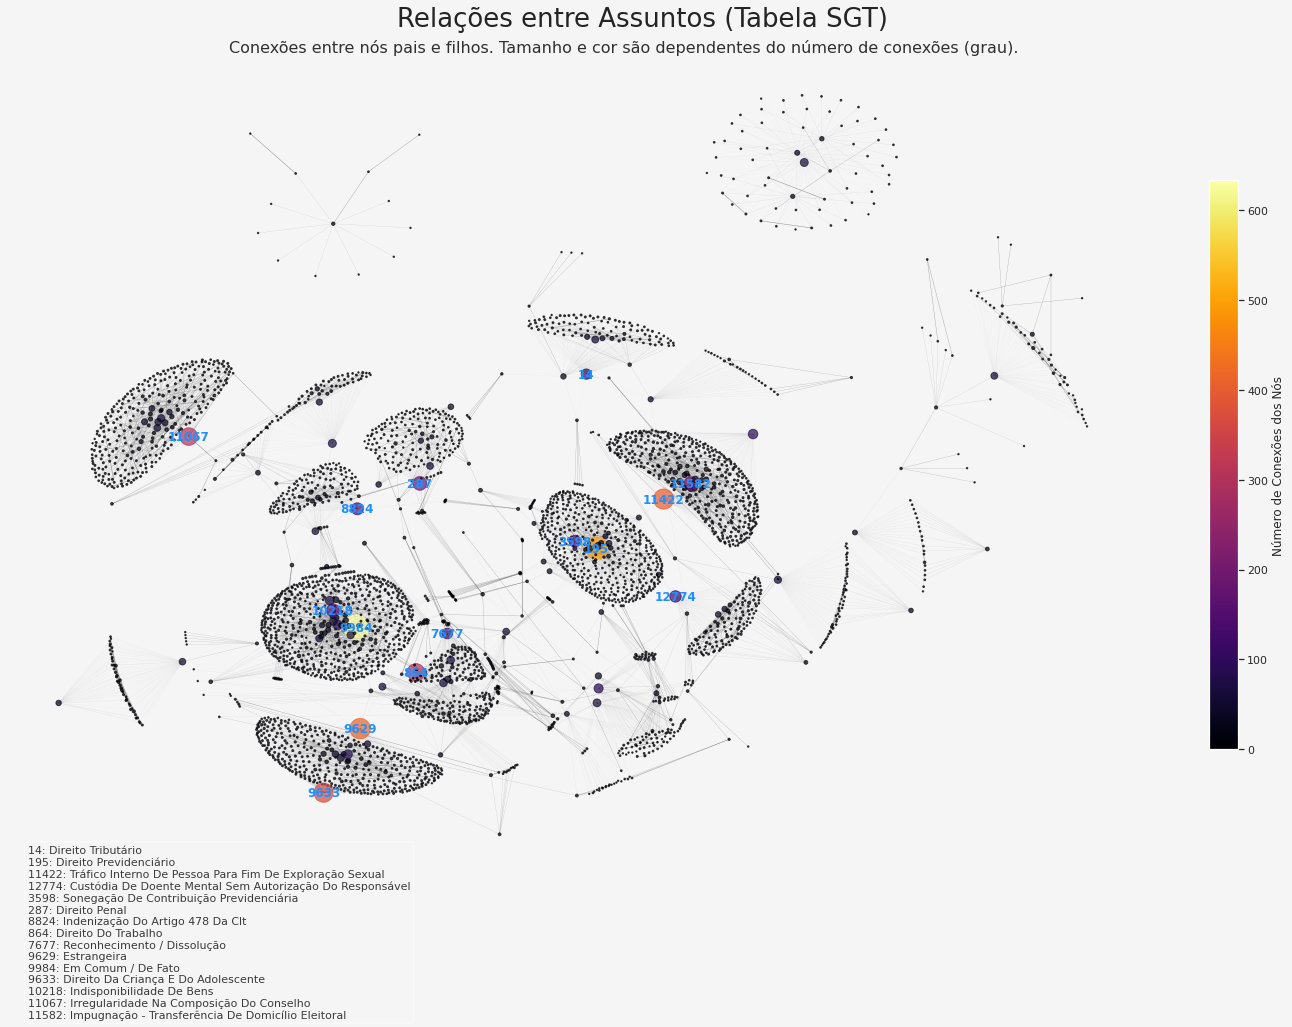

In [ ]:
plotar_grafo(G_assuntos, sgt_assuntos_df, salvar=True, titulo='Relações entre Assuntos (Tabela SGT)',nome_arq='grafo-assuntos', limite=100)

In [ ]:
# Preenchendo todos os valores ausentes com a string 'nan'
filtro_null = sgt_assuntos_df['cod_filhos'].isnull()
sgt_assuntos_df.loc[filtro_null, 'cod_filhos'] = 'nan'

# Criando tuplas no formato (Pai, Filho, #Filhos) para todo filho de um dado assunto pai
# Criando index e lista vazia
index = -1
lista_tuplas_assuntos = []

# Iterando por toda linha da coluna cod_filhos
for i in sgt_assuntos_df['cod_filhos']:
    if i != 'nan' and index != -1:
        # Acessando o valor codigo_assunto, que diz respeito ao código do assunto i
        codigo_assunto = int(sgt_assuntos_df.loc[index, 'codigo'])
        
        # Dividindo por vírgulas e criando uma lista de inteiros
        lista_filhos = list(i.split(','))
        lista_filhos = [int(x) for x in lista_filhos]

        # Iterando por todo item da lista recém-criada
        for filho in lista_filhos:
            # Criando a tupla e colocando-a numa lista de tuplas
            tupla = (codigo_assunto, filho, len(lista_filhos))
            lista_tuplas_assuntos.append(tupla)
        index+=1
    else:
        index+=1

# Criando um dataframe a partir da lista de tuplas
assuntos_df = pd.DataFrame(lista_tuplas_assuntos, columns=['Pai', 'Filho', 'Pesos'])

# Criando um grafo G a partir do dataset
G = nx.from_pandas_edgelist(assuntos_df, 'Pai', 'Filho', edge_attr='Pesos')

In [ ]:
# Cria o objeto fig e configura o background para uma cor específica
fig = plt.figure(figsize=(20,14))
fig.patch.set_facecolor('whitesmoke')

# d recebe os graus de cada um dos nós do grafo 
d = dict(nx.degree(G))

# define parâmetros (cor e tamanho dos nós e tamanho das arestas, com base no grau dos nós)
node_color = [(v+1)*2 for v in d.values()]
node_size = [v+1 for v in d.values()] 
edge_width = [1/(G[u][v]['Pesos']+1) for u,v in G.edges()]

# Calcula a posição dos nós
pos = nx.nx_pydot.graphviz_layout(G)

# Código necessário para exibir a colorbar do cmap utilizado para os nós
my_cmap = plt.cm.get_cmap('inferno')
colors = my_cmap(node_color)
sm = ScalarMappable(cmap=my_cmap, norm=plt.Normalize(0, max(node_color)))
sm.set_array([])
cbar = plt.colorbar(sm, shrink = 0.8)
cbar.set_ticklabels([])
cbar.set_ticks([])

# Desenhando o grafo
nx.draw_networkx(G, pos=pos, 
                 node_color=node_color,
                 node_size=node_size,
                 width=edge_width,
                 cmap=my_cmap,
                 alpha=0.7, with_labels=False, edge_color='.4')

# Definindo quais nós terão labels (somente os que tiverem grau maior que 100)
labels = dict_labels(G, 100)

# Criando texto de legenda descrevendo quais são os nós que estão sendo exibidos
texto = ''
for k, v in labels.items():
    # Pegando, do dataframe original, a descrição do dado código e formatando a string
    desc = str(sgt_assuntos_df.loc[sgt_assuntos_df['codigo']==k, 'descricao'].values[0])
    desc = desc.lower()
    desc = desc.title()
    if texto != '':
        texto = texto + '\n{}: {}'.format(k, desc)
    else:
        texto = texto + '{}: {}'.format(k, desc)

# Exibindo o texto
textstr = texto
props = dict(boxstyle='round', facecolor='gainsboro', alpha=0.5)
plt.text(0.05, 0.95, textstr, fontsize=11, color = '#262626', alpha = 0.9, bbox=props,
         verticalalignment='top')


# Desenhando os labels na imagem
nx.draw_networkx_labels(G, pos=pos, labels=labels, font_weight='bold',font_color='dodgerblue')


# Definindo um título
plt.title('Relações entre Assuntos (Tabela SGT)', color = '#171717', size=22, alpha=0.8, pad=20)

# Plotando o gráfico sem eixos
plt.axis('off')
plt.tight_layout();
plt.savefig('grafo-assuntos.png', dpi=600)

###Manipulação do arquivo sgt_classes.csv

In [ ]:
path = '/content/drive/My Drive/Dados/sgt_classes.csv'
sgt_classes_df = leitor_csv(path, 0, ';')

l, c = sgt_classes_df.shape
print('Há', l, 'linhas e', c, 'colunas')
sgt_classes_df.head()

Há 788 linhas e 5 colunas


,codigo,descricao,sigla,cod_pai,cod_filhos
0,2,PROCESSO CÍVEL E DO TRABALHO,ProcCivTrab,NaN,"158,175,197,214,1106,12133,159,165,169,1068,11..."
1,5,SUPERIOR TRIBUNAL DE JUSTIÇA,STJ,NaN,"1013,1015,1016,1017,1018,1019,1020,1021,1022,1..."
2,7,Procedimento Comum Cível,ProceComCiv,1107.0,NaN
3,22,Procedimento Sumário,ProSum,1107.0,NaN
4,26,Procedimentos Especiais,ProEsp,1107.0,"27,50,62,28,29,30,31,32,34,35,37,38,39,40,41,4..."


In [ ]:
contador_valor_nulo(sgt_classes_df)

0  valores nulos na coluna  codigo
0  valores nulos na coluna  descricao
23  valores nulos na coluna  sigla
10  valores nulos na coluna  cod_pai
705  valores nulos na coluna  cod_filhos


In [ ]:
distancia_nos(G_classes, 1384,2)

8

In [ ]:
G_classes = criar_grafo(sgt_classes_df)

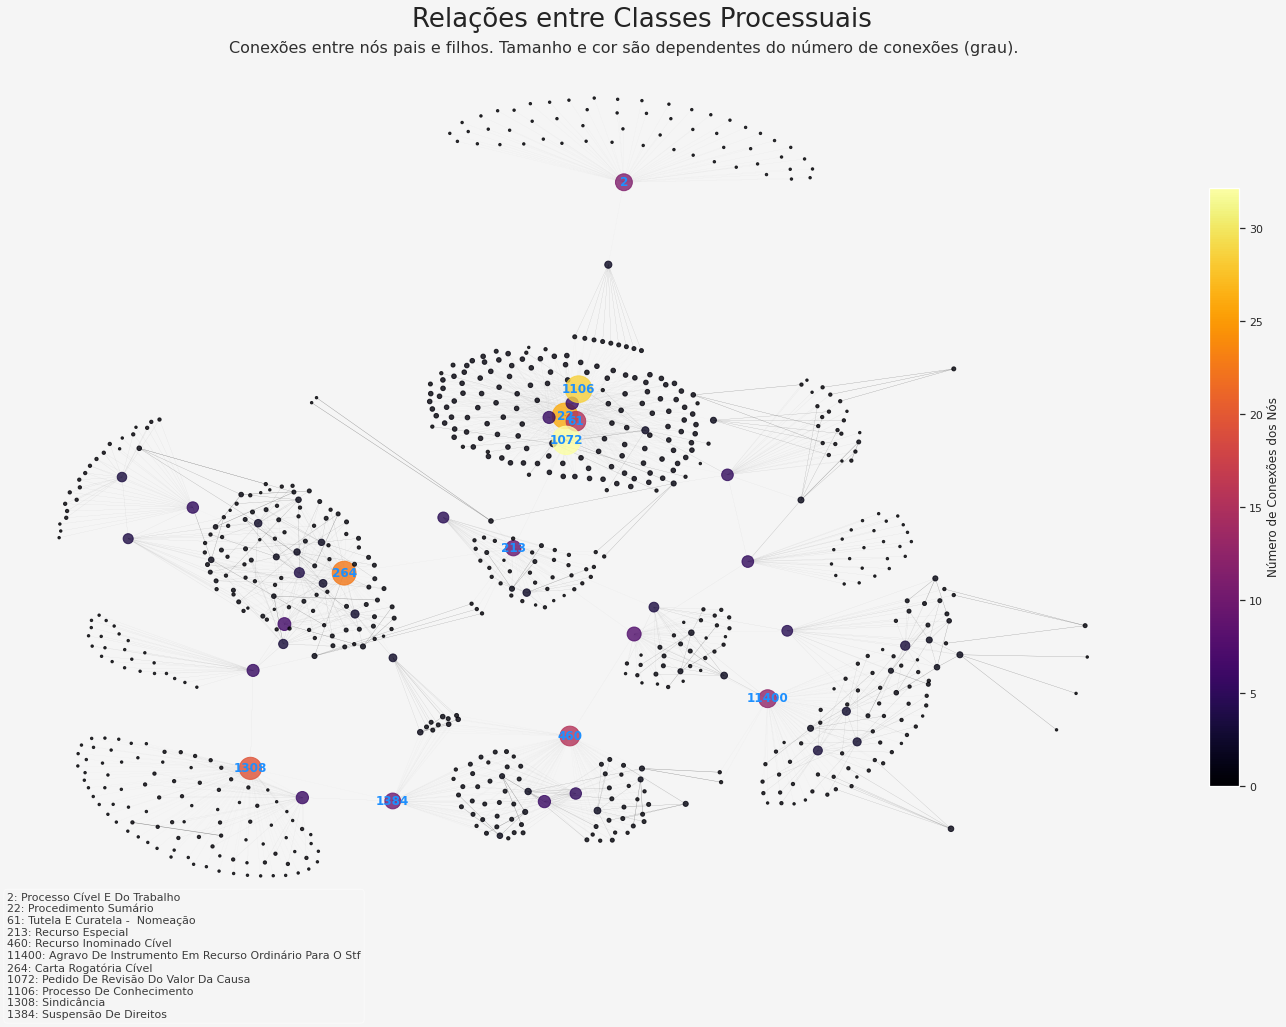

In [ ]:
plotar_grafo(G_classes, sgt_classes_df, salvar=True, titulo='Relações entre Classes Processuais', nome_arq='grafo-classes', limite=40, peso=5)

###Manipulação do arquivo sgt_movimentos.csv

In [ ]:
path = '/content/drive/My Drive/Dados/sgt_movimentos.csv'
sgt_movimentos_df = leitor_csv(path, 0, ';')

l, c = sgt_movimentos_df.shape
print('Há', l, 'linhas e', c, 'colunas')
sgt_movimentos_df.head()

Há 693 linhas e 4 colunas


,codigo,descricao,cod_pai,cod_filhos
0,1,Magistrado,NaN,"3,193,11009,7,11,25,56,63,83,108,113,117,122,1..."
1,3,Decisão,1.0,"7,11,25,56,63,83,108,113,117,122,133,138,146,1..."
2,7,Conversão,3.0,"266,821,12140,12473"
3,11,Declaração,3.0,"269,941,1003,12150,12151"
4,14,Serventuário,NaN,"15,18,48,104,865,12522,16,979,980,478,479,480,..."


In [ ]:
sgt_movimentos_df.to_csv("movimentos.csv", index=False)

In [ ]:
contador_valor_nulo(sgt_movimentos_df)

0  valores nulos na coluna  codigo
0  valores nulos na coluna  descricao
2  valores nulos na coluna  cod_pai
598  valores nulos na coluna  cod_filhos


In [ ]:
G_movimentos = criar_grafo(sgt_movimentos_df)

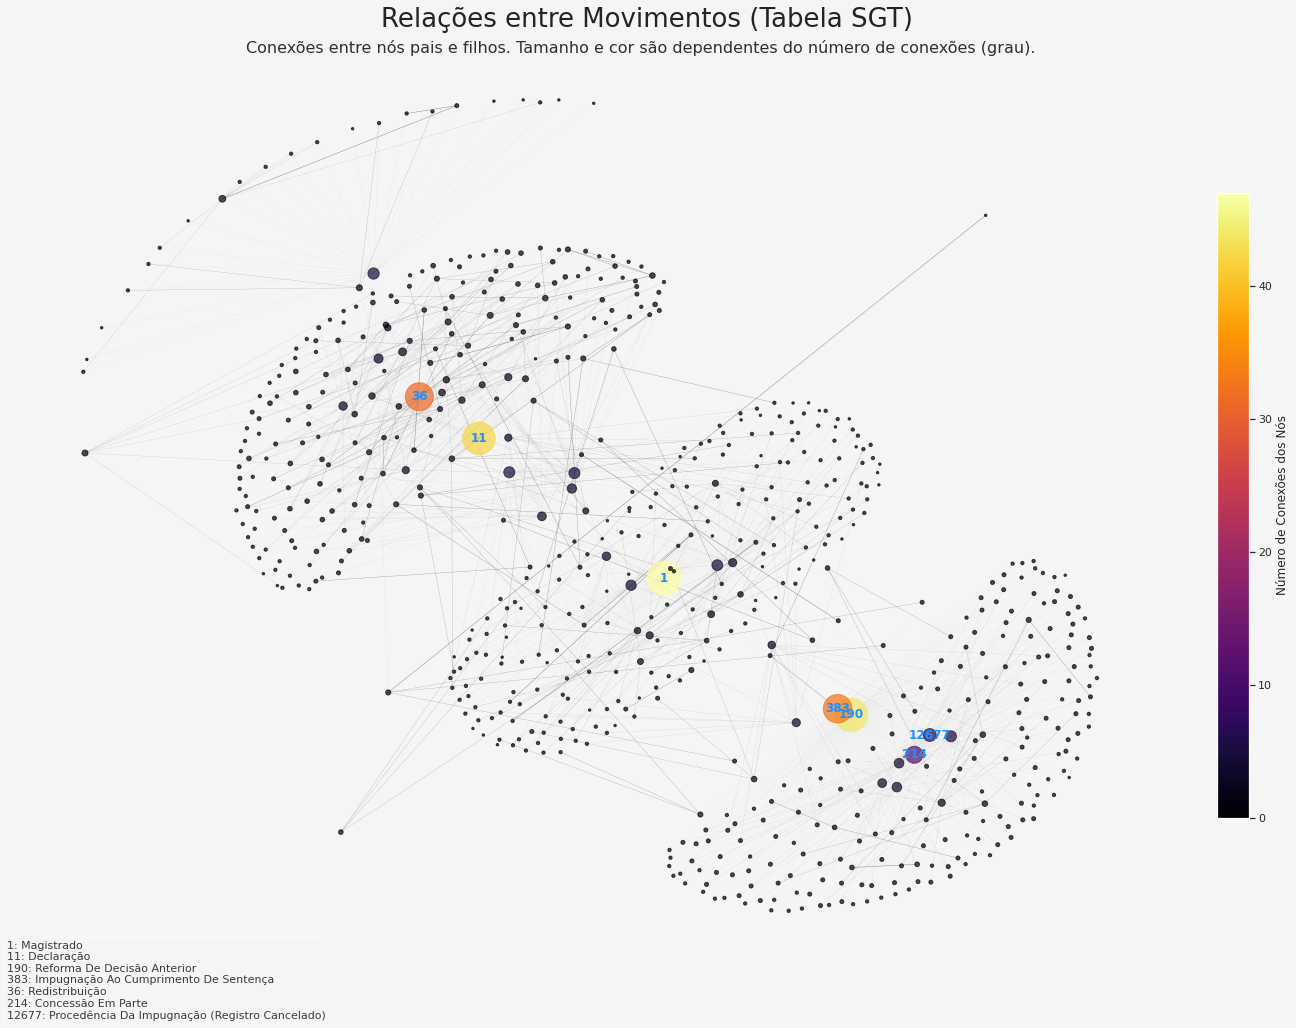

In [ ]:
plotar_grafo(G_movimentos, sgt_movimentos_df, salvar=True, titulo='Relações entre Movimentos (Tabela SGT)', nome_arq='grafo-movimentos',limite=25, peso=5)

# Obtendo os arquivos .pkl comprimidos em zip para submissão no GitHub


In [ ]:
for i in range(1,26):
    with open('drive/My Drive/Dados/Processos/processos-trt'+str(i)+'.pkl','rb') as f:
        df = pd.read_pickle(f)
    with open('drive/My Drive/Dados/Processos/processos-trt'+str(i)+'.pkl.zip','xb') as f:
        df.to_pickle(f,compression='zip')

In [ ]:
!mkdir drive/My\ Drive/Dados/Processos/Zipados
!mv drive/My\ Drive/Dados/Processos/*.zip drive/My\ Drive/Dados/Processos/Zipados